In [1]:
import os
import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import json
from PIL import Image
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from google.colab import drive
from operator import itemgetter
from datetime import datetime

In [2]:
class image_data_set(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return {'data': self.data[index], 'label': self.labels[index]}

In [3]:
def get_image_tensor(file_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    image = Image.open(file_path)
    return transform(image)

def remove_images_with_no_datetime(images):
    new_images = []
    for image in images:
        if("datetime" in image):
            new_images.append(image)
    return new_images

def get_sorted_images(coco_key):
    images = coco_key["images"]
    images = remove_images_with_no_datetime(images)
    return sorted(images, key=itemgetter("datetime"))

def flatten_list(data):
    return [image for batch in data for image in batch]

def get_data_sets(downloaded_data_dir, json_file_name):
    json_file = open(downloaded_data_dir + json_file_name)
    coco_key = json.load(json_file)
    images = get_sorted_images(coco_key)

    batch_data, batch_labels, data, labels = [], [], [], []
    previous_time_stamp = None
    for index, image in enumerate(images):
        time_stamp = datetime.strptime(image["datetime"], '%Y:%m:%d %H:%M:%S')
        file_name = image["file_name"]
        file_path = downloaded_data_dir + file_name

        if os.path.isfile(file_path):
            label = coco_key["annotations"][index]["category_id"]
            image_tensor = None
            try:
                image_tensor = get_image_tensor(file_path)
            except:
                print("Truncated image encountered, leaving out of training and testing")
                continue

            if index == 0 or (time_stamp - previous_time_stamp).total_seconds() < 60:
                batch_data.append(image_tensor)
                batch_labels.append(label)
            else:
                data.append(torch.stack(batch_data))
                labels.append(torch.FloatTensor(batch_labels))

                batch_data, batch_labels = [], []
                batch_data.append(image_tensor)
                batch_labels.append(label)

            previous_time_stamp = time_stamp


    batch_training_data, batch_testing_data, batch_training_labels, batch_testing_labels = train_test_split(data, labels, test_size = 0.20)
    training_data = flatten_list(batch_training_data)
    testing_data = flatten_list(batch_testing_data)
    training_labels = flatten_list(batch_training_labels)
    testing_labels = flatten_list(batch_testing_labels)

    print("\nNumber of training photos: " + str(len(training_data)))
    print("Number of testing photos: " + str(len(testing_data)))
    print("Number of batches for testing: " + str(len(batch_testing_data)))

    json_file.close()

    return training_data, testing_data, training_labels, testing_labels, batch_testing_data, batch_testing_labels

In [21]:
def print_image(image_tensor, prediction, downloaded_data_dir, index):
    image_file_name = downloaded_data_dir + str(prediction.item()) + "_" + str(index) + ".png"

    #Alternative normalized RGB visualization: plt.imshow(image_tensor.cpu().permute(1, 2, 0).numpy())
    plt.imshow(image_tensor[0].cpu(), cmap="gray")
    plt.title("Incorrectly Predicted " + str(prediction.item()) + " Animals Present")
    plt.show()
    #plt.imsave(image_file_name, image_tensor[0].cpu(), cmap="gray")

def print_testing_analysis(all_labels, all_predictions, title, downloaded_data_dir):
    subplot = plt.subplot()

    cf_matrix = confusion_matrix(all_labels, all_predictions, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    cf_matrix = np.flip(cf_matrix, axis=0)
    sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')

    subplot.set_xlabel('Predictions')
    subplot.set_ylabel('Labels')
    subplot.set_title(title + ' Testing Confusion Matrix')
    subplot.xaxis.set_ticklabels([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    subplot.yaxis.set_ticklabels([9, 8, 7, 6, 5, 4, 3, 2, 1, 0])

    plot_file_name = downloaded_data_dir + title + "_Confusion_Matrix.png"
    #plt.savefig(plot_file_name)
    plt.show()

    accuracy = accuracy_score(all_labels, all_predictions)
    print(title + " Accuracy: " + str(accuracy))

    precision, recall, f_score, support = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')
    print(title + " Precision: " + str(precision))
    print(title + " Recall: " + str(recall))
    print(title + " F-Score: " + str(f_score))

def train(model, training_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    num_correct = 0
    for batch in training_loader:
        data, labels = batch['data'].to(device), batch['label'].to(device)
        optimizer.zero_grad()
        output = model(data).flatten()

        loss = criterion(output, labels)
        running_loss += loss.item()
        num_correct += (output.round() == labels).sum().item()
        loss.backward()
        optimizer.step()

    loss = running_loss/len(training_loader.dataset)
    accuracy = num_correct/len(training_loader.dataset)
    return loss, accuracy

def test(model, testing_loader, criterion, print_incorrect_images, downloaded_data_dir):
    model.eval()
    running_loss = 0.0
    num_correct = 0
    all_labels, all_predictions = [], []

    for i, batch in enumerate(testing_loader):
        data, labels = batch['data'].to(device), batch['label'].to(device)
        output = model(data).flatten()

        loss = criterion(output, labels)
        running_loss += loss.item()
        for index, prediction in enumerate(output.round()):
            all_predictions.append(prediction.cpu().item())
            if(prediction == labels[index]):
                num_correct += 1
            elif(print_incorrect_images):
                print_image(data[index], prediction, downloaded_data_dir, i)

        all_labels.extend(labels.cpu())

    loss = running_loss/len(testing_loader.dataset)
    accuracy = num_correct/len(testing_loader.dataset)
    return loss, accuracy, all_labels, all_predictions

def test_batch(model, batch_testing_loader, criterion, print_incorrect_images, downloaded_data_dir):
    model.eval()
    running_loss = 0.0
    num_correct = 0
    all_labels, all_predictions = [], []

    for batch in batch_testing_loader:
        data, labels = torch.squeeze(batch['data'], dim=0).to(device), batch['label'].to(device)

        # This is to prevent cuda memory issues for large batches
        max_prediction = 0
        for image in data:
            image = torch.unsqueeze(image, dim=0)
            output = model(image).flatten()
            max_prediction = max(max_prediction, output.round().item())

        max_prediction = torch.tensor(max_prediction).to(device)
        max_label = torch.max(labels)

        loss = criterion(max_prediction, max_label)
        running_loss += loss.item()

        if max_prediction == max_label:
            num_correct += 1

        all_predictions.append(max_prediction.cpu())
        all_labels.append(max_label.cpu())

    loss = running_loss/len(batch_testing_data_set)
    accuracy = num_correct/len(batch_testing_data_set)
    return loss, accuracy, all_labels, all_predictions

In [22]:
def train_and_test(num_epochs, model, model_name, training_loader, testing_loader, batch_testing_loader, device, criterion, downloaded_data_dir):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    highest_batch_testing_accuracy = 0.0

    for epoch in range(num_epochs):
        print("Epoch: " + str(epoch))

        training_loss, training_accuracy = train(model, training_loader, criterion, optimizer)
        print("training loss: " + str(training_loss) + " and training accuracy: " + str(training_accuracy))

        testing_loss, testing_accuracy, _, _ = test(model, testing_loader, criterion, False, downloaded_data_dir)
        print("testing loss: " + str(testing_loss) + " and testing accuracy: " + str(testing_accuracy))

        batch_testing_loss, batch_testing_accuracy, batch_labels, batch_predictions = test_batch(model, batch_testing_loader, criterion, False, downloaded_data_dir)
        print("batch testing loss: " + str(batch_testing_loss) + " and batch testing accuracy: " + str(batch_testing_accuracy))

        if highest_batch_testing_accuracy < batch_testing_accuracy:
            print("Highest batch testing accuracy achieved, saving weights")
            highest_batch_testing_accuracy = batch_testing_accuracy
            torch.save(model, "saved_models/batch_count_" + model_name + ".pt")
            print_testing_analysis(batch_labels, batch_predictions, model_name, downloaded_data_dir)

# Declaring Constants

In [6]:
num_epochs = 3
num_classes = 10
batch_size = 10
json_file_name = "animal_count_key.json"
downloaded_data_dir = "animal_count_manually_labeled_wildlife_data/"

print(torch.__version__)
print(torchvision.__version__)
print("torch.cuda.is_available(): " + str(torch.cuda.is_available()))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
criterion = nn.MSELoss()

2.0.1+cu118
0.15.2+cu118
torch.cuda.is_available(): True


# Loading Data

In [7]:
# Use this to connect to Google Drive in Google Colab
drive.mount('/content/drive')

# Use this to unzip file in Google Colab
!unzip -qq drive/MyDrive/animal_count_manually_labeled_wildlife_data

Mounted at /content/drive


In [8]:
training_data, testing_data, training_labels, testing_labels, batch_testing_data, batch_testing_labels = get_data_sets(downloaded_data_dir, json_file_name)
training_data_set = image_data_set(training_data, training_labels)
testing_data_set = image_data_set(testing_data, testing_labels)
batch_testing_data_set = image_data_set(batch_testing_data, batch_testing_labels)
training_loader = DataLoader(dataset = training_data_set, batch_size = batch_size, shuffle = True)
testing_loader = DataLoader(dataset = testing_data_set, batch_size = batch_size, shuffle = True)
batch_testing_loader = DataLoader(dataset = batch_testing_data_set, batch_size = 1, shuffle = True)


Number of training photos: 3143
Number of testing photos: 826
Number of batches for testing: 155


# Declaring Models

In [17]:
resnet50 = models.resnet50(weights = models.ResNet50_Weights.DEFAULT)
in_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(in_features, 1)

resnet152 = models.resnet152(weights = models.ResNet152_Weights.DEFAULT)
in_features = resnet152.fc.in_features
resnet152.fc = nn.Linear(in_features, 1)

vit_l_16 = models.vit_l_16(weights = models.ViT_L_16_Weights.DEFAULT)
in_features = vit_l_16.heads[0].in_features
vit_l_16.heads[0] = nn.Linear(in_features, 1)

if torch.cuda.device_count() > 1:
    print("Multiple GPUs available, using: " + str(torch.cuda.device_count()))
    resnet50 = nn.DataParallel(resnet50)
    resnet152 = nn.DataParallel(resnet152)
    vit_l_16 = nn.DataParallel(vit_l_16)

# Training


Training and Testing ResNet50
Epoch: 0
training loss: 0.026543743325254547 and training accuracy: 0.8631880369074133
testing loss: 0.021721639495103938 and testing accuracy: 0.847457627118644
batch testing loss: 0.2967741935483871 and batch testing accuracy: 0.8903225806451613
Highest batch testing accuracy achieved, saving weights


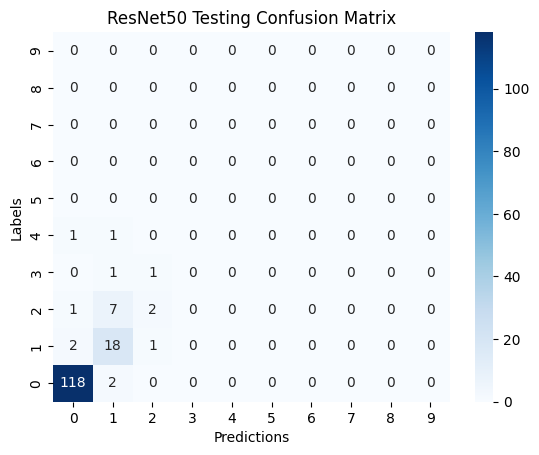

ResNet50 Accuracy: 0.8903225806451613
ResNet50 Precision: 0.8651616550265322
ResNet50 Recall: 0.8903225806451613
ResNet50 F-Score: 0.870980233842404
Epoch: 1


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


training loss: 0.0215536728444279 and training accuracy: 0.8829144129812281
testing loss: 2.2722895116484376 and testing accuracy: 0.7651331719128329
batch testing loss: 9.070967741935483 and batch testing accuracy: 0.8451612903225807
Epoch: 2
training loss: 0.02239163530372069 and training accuracy: 0.862869869551384
testing loss: 0.024328206386614464 and testing accuracy: 0.8583535108958837
batch testing loss: 0.25806451612903225 and batch testing accuracy: 0.864516129032258


In [23]:
print("\nTraining and Testing ResNet50")
train_and_test(num_epochs, resnet50, "ResNet50", training_loader, testing_loader, batch_testing_loader, device, criterion, downloaded_data_dir)


Training and Testing ResNet152
Epoch: 0
training loss: 0.01854358121926158 and training accuracy: 0.8924594336621062
testing loss: 0.02774113516850943 and testing accuracy: 0.7917675544794189
batch testing loss: 0.32903225806451614 and batch testing accuracy: 0.8387096774193549
Highest batch testing accuracy achieved, saving weights


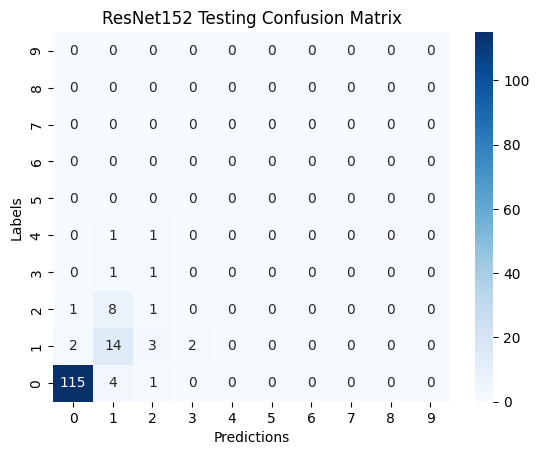

ResNet152 Accuracy: 0.8387096774193549
ResNet152 Precision: 0.831469186909318
ResNet152 Recall: 0.8387096774193549
ResNet152 F-Score: 0.8331797235023041
Epoch: 1


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


training loss: 0.016662190272549657 and training accuracy: 0.9055042952593064
testing loss: 0.017904291468315597 and testing accuracy: 0.8716707021791767
batch testing loss: 0.21935483870967742 and batch testing accuracy: 0.8709677419354839
Highest batch testing accuracy achieved, saving weights


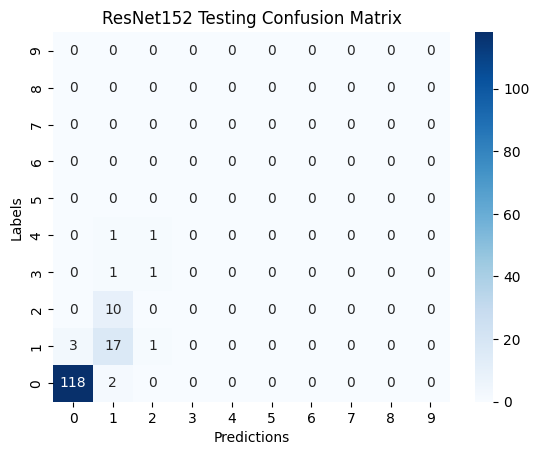

ResNet152 Accuracy: 0.8709677419354839
ResNet152 Precision: 0.8292962736818569
ResNet152 Recall: 0.8709677419354839
ResNet152 F-Score: 0.8467170495145332
Epoch: 2


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


training loss: 0.015082240934574305 and training accuracy: 0.9121858097359211
testing loss: 0.02372556706646922 and testing accuracy: 0.8462469733656174
batch testing loss: 0.2645161290322581 and batch testing accuracy: 0.8774193548387097
Highest batch testing accuracy achieved, saving weights


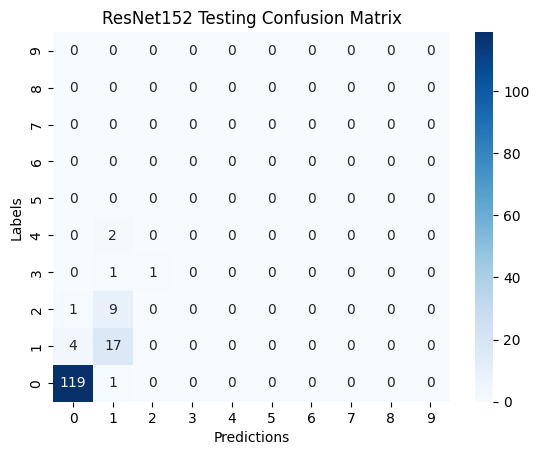

ResNet152 Accuracy: 0.8774193548387097
ResNet152 Precision: 0.8197502601456816
ResNet152 Recall: 0.8774193548387097
ResNet152 F-Score: 0.8454785827604443


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
print("\nTraining and Testing ResNet152")
train_and_test(num_epochs, resnet50, "ResNet152", training_loader, testing_loader, batch_testing_loader, device, criterion, downloaded_data_dir)


Training and Testing ViTLarge16
Epoch: 0
training loss: 0.014060122560228719 and training accuracy: 0.9125039770919504
testing loss: 0.0216928521886053 and testing accuracy: 0.837772397094431
batch testing loss: 0.2 and batch testing accuracy: 0.8774193548387097
Highest batch testing accuracy achieved, saving weights


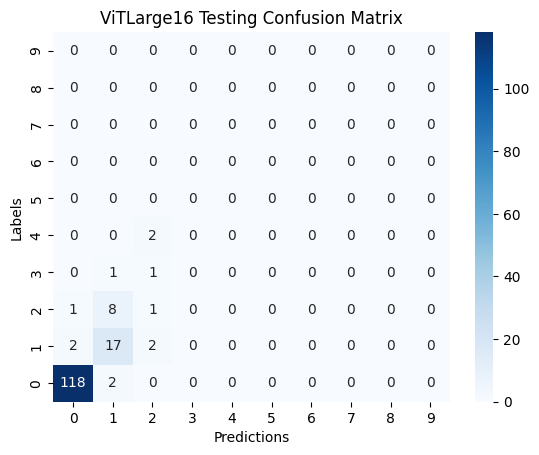

ViTLarge16 Accuracy: 0.8774193548387097
ViTLarge16 Precision: 0.8480094197102993
ViTLarge16 Recall: 0.8774193548387097
ViTLarge16 F-Score: 0.8602051742929804
Epoch: 1


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


training loss: 0.01118564003114516 and training accuracy: 0.9220489977728286
testing loss: 0.024938164204308316 and testing accuracy: 0.8244552058111381
batch testing loss: 0.22580645161290322 and batch testing accuracy: 0.8838709677419355
Highest batch testing accuracy achieved, saving weights


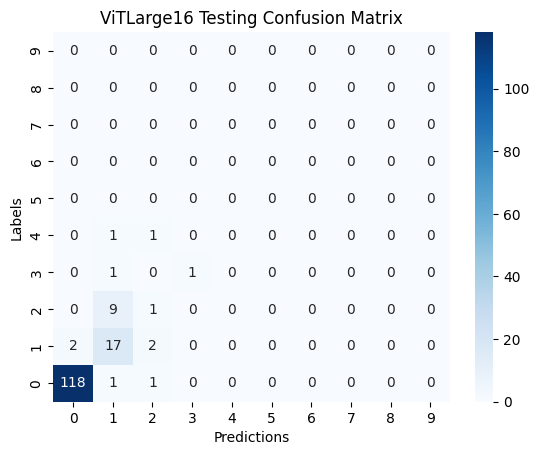

ViTLarge16 Accuracy: 0.8838709677419355
ViTLarge16 Precision: 0.8665183537263628
ViTLarge16 Recall: 0.8838709677419355
ViTLarge16 F-Score: 0.8706236559139786
Epoch: 2


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


training loss: 0.013692576538968552 and training accuracy: 0.9090041361756284
testing loss: 0.023872369979060035 and testing accuracy: 0.8292978208232445
batch testing loss: 0.18064516129032257 and batch testing accuracy: 0.8774193548387097


In [25]:
print("\nTraining and Testing ViTLarge16")
train_and_test(num_epochs, resnet50, "ViTLarge16", training_loader, testing_loader, batch_testing_loader, device, criterion, downloaded_data_dir)